<a href="https://colab.research.google.com/github/velamalaappu/icc--unsupervisedml-analysis/blob/main/MODULE4_BOOK_RECOMMENDATION_SYSTEM_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Book Recommendation System**

**PROBLEM STATEMENT**

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such
web services, recommender systems have taken more and more place in our lives. From
e-commerce (suggest to buyers articles that could interest them) to online advertisement
(suggest to users the right contents, matching their preferences), recommender systems are
today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant
items to users (items being movies to watch, text to read, products to buy, or anything else
depending on industries).

Recommender systems are really critical in some industries as they can generate a huge
amount of income when they are efficient or also be a way to stand out significantly from
competitors. The main objective is to create a book recommendation system for users.

Content

The Book-Crossing dataset comprises 3 files.

● Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.

● Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.

● Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,expressed by 0.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Dataset Description**
we have 3 files in our dataset which is extracted from some books selling websites.

Books – first are about books which contain all the information related to books like an author, title, publication year, etc.

Users – The second file contains registered user’s information like user id, location.

ratings –  Ratings contain information like which user has given how much rating to which book.

So based on all these three files we can build a powerful collaborative filtering model. let’s get started.

# **Load Data**
let us start while importing libraries and load datasets. while loading the file we have some problems like.

 The values in the CSV file are separated by semicolons, not by a comma.

There are some lines which not work like we cannot import it with pandas and It throws an error because python is Interpreted language.

Encoding of a file is in Latin

So while loading data we have to handle these exceptions and after running the below code you will get some warning and it will show which lines have an error that we have skipped while loading.

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from imageio import imread
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
import requests
from mlxtend.frequent_patterns import apriori, association_rules
books = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HG/Books.csv",sep=',',  index_col=False, dtype='unicode')
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HG/Ratings.csv")
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HG/Users.csv")

# **Preprocessing Data**
Now in the books file, we have some extra columns which are not required for our task like image URLs. And we will rename the columns of each file as the name of the column contains space, and uppercase letters so we will correct as to make it easy to use.

In [ ]:
user_rating_df = ratings.merge(users, how="left", on='User-ID')
book_user_rating = books.merge(user_rating_df, how="left", on='ISBN')
book_user_rating = book_user_rating[['ISBN', 'Book-Title', 'Book-Author', 'User-ID', 'Book-Rating','Image-URL-L']]
book_user_rating.reset_index(drop=True, inplace=True)
book_user_rating.dropna(inplace=True)
ratings.rename(columns = {'User-ID':'user_id', 'Book-Rating':'rating'}, inplace=True)

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
#the process of giving unique id to books
bookid = []
bookname = []
for i, j in enumerate(book_user_rating["Book-Title"].unique()):
    bookid.append(i)
    bookname.append(j)
dictbook = {'bookid': bookid, 'Book-Title': bookname, }
dfbook = pd.DataFrame(dictbook)
book_user_rating = book_user_rating.merge(dfbook, how="left", on='Book-Title')

In [ ]:
#unique id issuance to user
userid = []
username = []
for i, j in enumerate(book_user_rating["User-ID"].unique()):
    userid.append(i)
    username.append(j)
dictuser = {'userid': userid, 'User-ID': username, }
dfuser = pd.DataFrame(dictuser)
book_user_rating = book_user_rating.merge(dfuser, how="left", on='User-ID')

book = book_user_rating[["Book-Title", "Book-Rating", "bookid", "userid","Image-URL-L"]]

In [ ]:
book.rename(columns={"Book-Title": "title", "Book-Rating": "rating", }, inplace=True)

rating_counts = pd.DataFrame(book["title"].value_counts())

rare_books = rating_counts[rating_counts["title"] < 200].index


common_books = book[~book["title"].isin(rare_books)]

common_books.drop_duplicates(inplace=True)

common_books["rating"].astype(int)

user_book_df = common_books.pivot_table(index=["userid"], columns=["bookid"], values="rating")


user_book_df.head()

bookid,5,18,26,27,28,37,38,39,46,47,...,7552,7711,8602,9256,9824,9957,10422,12055,14137,14732
userid,,,,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.5,7.0,6.0,0.0,10.0,6.0,10.0,8.0,3.5,0.0,...,NaN,7.0,3.25,9.0,9.5,0.0,5.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def item_based_recommender(kitap, data):
    kitap_ad = data[kitap]

    return data.corrwith(kitap_ad).sort_values(ascending=False).head(10)


In [ ]:
book.head()

,title,rating,bookid,userid,Image-URL-L
0,Classical Mythology,0.0,0,0,http://images.amazon.com/images/P/0195153448.0...
1,Clara Callan,5.0,1,1,http://images.amazon.com/images/P/0002005018.0...
2,Clara Callan,0.0,1,2,http://images.amazon.com/images/P/0002005018.0...
3,Clara Callan,8.0,1,3,http://images.amazon.com/images/P/0002005018.0...
4,Clara Callan,0.0,1,4,http://images.amazon.com/images/P/0002005018.0...


In [ ]:
af=item_based_recommender(7711,user_book_df)

In [ ]:
af.head()

bookid
770     1.000000
46      1.000000
7711    1.000000
6754    0.962771
1370    0.960244
dtype: float64

In [ ]:
af.index[0]

770

In [ ]:
book_user_rating.head()

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating,Image-URL-L,bookid,userid
0,0195153448,Classical Mythology,Mark P. O. Morford,2.0,0.0,http://images.amazon.com/images/P/0195153448.0...,0,0
1,0002005018,Clara Callan,Richard Bruce Wright,8.0,5.0,http://images.amazon.com/images/P/0002005018.0...,1,1
2,0002005018,Clara Callan,Richard Bruce Wright,11400.0,0.0,http://images.amazon.com/images/P/0002005018.0...,1,2
3,0002005018,Clara Callan,Richard Bruce Wright,11676.0,8.0,http://images.amazon.com/images/P/0002005018.0...,1,3
4,0002005018,Clara Callan,Richard Bruce Wright,41385.0,0.0,http://images.amazon.com/images/P/0002005018.0...,1,4


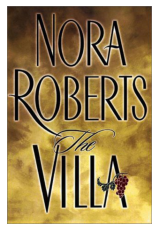

In [ ]:
url0=book_user_rating[book_user_rating["bookid"]==af.index[0]]["Image-URL-L"].to_list()[0]
im0 = imread(url0)
           
plt.figure(1)
plt.axis(False)
plt.imshow(im0)

# **Summarize the dataset**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt # visualization
!pip install seaborn as sns -q # visualization with seaborn v0.11.1
import seaborn as sns # visualization
import missingno as msno # missing values pattern visualization

import warnings # supress warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import math


plt.style.use('bmh')

# set pandas display option
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Load the data 
Books_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HG/Books.csv')
Ratings_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HG/Ratings.csv')
Users_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HG/Users.csv')

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [ ]:
# display the dataset
Ratings_df.head().style.set_caption('Sample of Ratings data')

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# dimension of dataset
print(f'''\t  Book_df shape is {Books_df.shape}
          Ratings_df shape is {Ratings_df.shape}
          Users_df shape is {Users_df.shape}''')

	  Book_df shape is (271360, 8)
          Ratings_df shape is (1149780, 3)
          Users_df shape is (278858, 3)


In [ ]:
def missing_zero_values_table(df):
    mis_val=df.isnull().sum()
    mis_val_percent=round(df.isnull().mean().mul(100),2)
    mz_table=pd.concat([mis_val,mis_val_percent],axis=1)
    mz_table=mz_table.rename(
    columns={df.index.name:'col_name',0:'Missing Values',1:'% of Total Values'})
    mz_table['Data_type']=df.dtypes
    mz_table=mz_table.sort_values('% of Total Values',ascending=False)
    print(f"Your selected dataframe has "+str(df.shape[1])+" columns and "+str(df.shape[0])+" Rows.\n"
         "There are "+str(mz_table[mz_table.iloc[:,1] != 0].shape[0])+
          " columns that have missing values.")
    return mz_table.reset_index()

In [ ]:
missing_zero_values_table(Users_df)

In [ ]:
missing_zero_values_table(Ratings_df)

Your selected dataframe has 3 columns and 1149780 Rows.
There are 0 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type
0,User-ID,0,0.0,int64
1,ISBN,0,0.0,object
2,Book-Rating,0,0.0,int64


In [ ]:
missing_zero_values_table(Books_df)

Your selected dataframe has 8 columns and 271360 Rows.
There are 0 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type
0,ISBN,0,0.0,object
1,Book-Title,0,0.0,object
2,Book-Author,1,0.0,object
3,Year-Of-Publication,0,0.0,object
4,Publisher,2,0.0,object
5,Image-URL-S,0,0.0,object
6,Image-URL-M,0,0.0,object
7,Image-URL-L,3,0.0,object


Check outlier data in Age and Book-Rating column

Text(0.5, 1.0, 'Find outlier data in Age column')

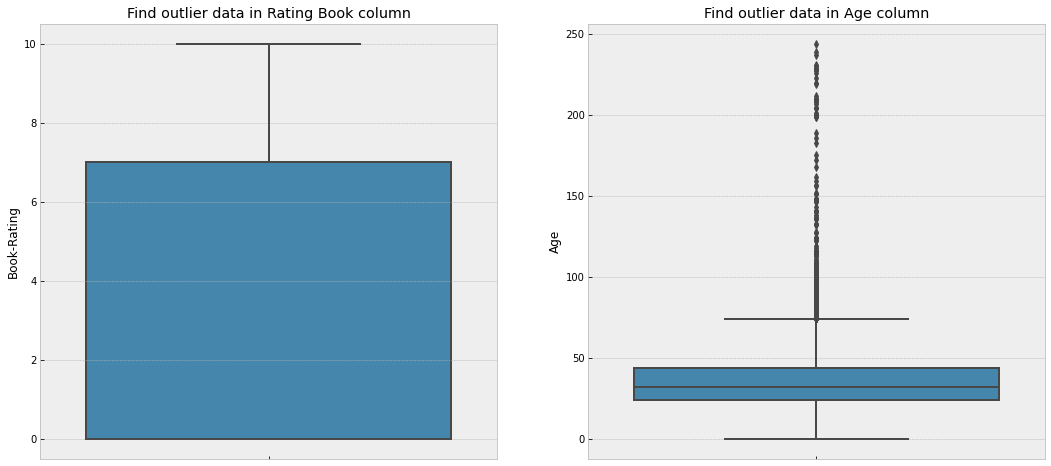

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.boxplot(y='Book-Rating', data=Ratings_df,ax=ax[0])
ax[0].set_title('Find outlier data in Rating Book column')
sns.boxplot(y='Age', data=Users_df,ax=ax[1])
ax[1].set_title('Find outlier data in Age column')

In [ ]:
print(sorted(Users_df.Age.unique()))

In [ ]:
Users_df.Location.unique()

In [ ]:
len(Users_df.Location.unique())

57339 unique Value it's really hard to understand
so use regex and create column country

In [ ]:
Books_df['Book-Author'].describe()

In [ ]:
print(Books_df['Year-Of-Publication'].unique().tolist())

Year of publication 2037 !!
'Gallimard' , 'DK Publishing Inc' , type of sum year is string

In [ ]:
1.0 - (np.count_nonzero(Ratings_df)/float(Ratings_df.size))

In [ ]:
sorted(Ratings_df['Book-Rating'].unique())

In [ ]:
Ratings_df.shape[0]

In [ ]:
usersCount=Users_df.shape[0]
booksCount=Books_df.shape[0]
print(f'Users : {usersCount}')
print(f'Books : {booksCount}')
print(f'Total : {usersCount*booksCount}')

Users rated 1149780 books, but there are 271360 books
so users did not rate all books


In [ ]:
ratings_new = Ratings_df[Ratings_df.ISBN.isin(Books_df.ISBN)]
ratings_new = ratings_new[Ratings_df['User-ID'].isin(Users_df['User-ID'])]

In [ ]:
print("Users or books aren't in dataset")
print(f'Total : {Ratings_df.shape[0] - ratings_new.shape[0]}')

In [ ]:
sparsity = round(1.0 - len(ratings_new)/float(usersCount*booksCount),6)
sparsity

Age column has 39 percent null data
and age column has outlier data


# **Visualization and Modeling**

Steps:

1.rename columns names :))

2.Create country column to analyze better

3.Fill Na value in Country column

4.So me data in Country Column has Misspellings

5.Create rating_Avg and number_of_rating to analyze better

6.users more in which countries

7.Age column has outlier data

8.Fill Na value in Age column

9.Fill Na value in Book data frame's Author column

10.Fill Na value in Book data frame's Publisher column

11.Book data frame's Year of Publication column has two string value and some integer value type is string

12.Book data frame's Year of Publication has outlier data

13.Fill Na value in Book data frame's Year of Publication

14.join three data frames together

15.Delete user and book columns they rated but aren't in the dataset

16.Rating_book value must be 1 to 10

17.drop three unhelpful columns 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'


In [ ]:
Ratings_df.rename(columns={'User-ID':'user_id','Book-Rating':'book_rating'},inplace=True)
Users_df.rename(columns={'User-ID':'user_id'},inplace=True)
Books_df.rename(columns={'Book-Title':'Book_Title','Book-Author':'Book_Author',
                         'Year-Of-Publication':'Year_Of_Publication'},inplace=True)

### **Country Column**

In [ ]:
Users_df['Country']='Iran'
for i in Users_df:
    Users_df['Country']=Users_df.Location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')   

368 of users Country column is Nan so must be fill it

In [ ]:
len(Users_df.Country.unique())

530

In [ ]:
Users_df.isnull().sum()

user_id          0
Location         0
Age         110762
Country        368
dtype: int64

In [ ]:
Users_df.loc[Users_df.Country.isnull(),'Country']='other'

So I don't have any idea Location column has 57339 unique value
for this I use Regex and create country column
but we have 195 Countries in the World !!
But it's better than 57339 unique Location value :))

In [ ]:
pd.crosstab(Users_df.Country,Ratings_df.book_rating).T.style.background_gradient()

Some data has Misspellings

In [ ]:
Users_df['Country'].replace(['','alachua','america','austria','autralia','cananda','geermany','italia','united kindgonm','united sates','united staes','united state','united states','us'],
                           ['other','usa','usa','australia','australia','canada','germany','italy','united kingdom','usa','usa','usa','usa','usa'],inplace=True)

Create Column 'count rate'
user participation in rated
and even users rated the books zero

In [ ]:
# Create column Count_All_Rate
Ratings_df['Count_All_Rate']=Ratings_df.groupby('ISBN')['user_id'].transform('count')

### **Country and Users**

In [ ]:
cm=sns.light_palette('green',as_cmap=True)
popular=Users_df.Country.value_counts().to_frame()[:10]
popular.rename(columns={'Country':'Count_Users_Country'},inplace=True)
popular.style.background_gradient(cmap=cm)

,Count_Users_Country
usa,139735
canada,21659
united kingdom,18557
germany,17074
spain,13258
australia,12935
italy,11282
other,4956
france,3487
portugal,3390


In the below chart there is one row has named 'other' it's mean
location is Nan, or regex it's not able to read

**Age Columns**

In [ ]:
# outlier data became NaN
Users_df.loc[(Users_df.Age > 100 ) | (Users_df.Age < 5),'Age']=np.nan

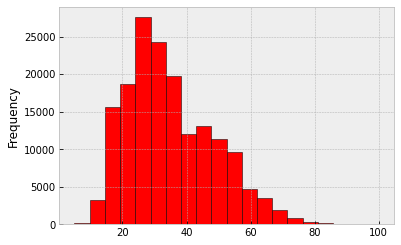

In [ ]:
Users_df.Age.plot.hist(bins=20,edgecolor='black',color='red')

In [ ]:
round(Users_df.Age.skew(axis=0,skipna=True),3)

0.675

Age has positive Skewness (right tail)
so we I have one idea to fill Na value from Median
for this we don't like to fill Na value just for one range of age for handle it I use country column to fill Na

In [ ]:
# Series of users data live in which country 
countryUsers = Users_df.Country.value_counts()

In [ ]:
country=countryUsers[countryUsers>=5].index.tolist()

In [ ]:
# Range of Age users in country register in this library and had participation
RangeOfAge = Users_df.loc[Users_df.Country.isin(country)][['Country','Age']].groupby('Country').agg(np.mean).to_dict()

In [ ]:
for k,v in RangeOfAge['Age'].items():
    Users_df.loc[(Users_df.Age.isnull())&(Users_df.Country== k),'Age'] = v
    

In [ ]:
Users_df.isnull().sum()

user_id       0
Location      0
Age         330
Country       0
dtype: int64

POF again we have 330 null Value
for fill in it
Age has positive Skewness (right tail)
so we I have one idea to fill Na value from Median

In [ ]:
medianAge = int(Users_df.Age.median())
Users_df.loc[Users_df.Age.isnull(),'Age']=medianAge

In [ ]:
Users_df.isnull().sum()

user_id     0
Location    0
Age         0
Country     0
dtype: int64

**Book Author column has Nan value**

In [ ]:
Books_df[Books_df.Book_Author.isnull()]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


**Publisher column has Nan value**

In [ ]:
Books_df.loc[(Books_df.ISBN=='9627982032'),'Book_Author']='other'

In [ ]:
Books_df[Books_df.Publisher.isnull()]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [ ]:
Books_df.loc[(Books_df.ISBN=='193169656X'),'Publisher']='other'
Books_df.loc[(Books_df.ISBN=='1931696993'),'Publisher']='other'

In [ ]:
Books_df[Books_df.Year_Of_Publication=='Gallimard']

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [ ]:
Books_df[Books_df.Year_Of_Publication=='DK Publishing Inc']

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [ ]:
Books_df.loc[Books_df.ISBN=='2070426769','Year_Of_Publication']=2003
Books_df.loc[Books_df.ISBN=='2070426769','Book_Author']='Gallimard'

**Year of Publication**

In [ ]:
Books_df.loc[Books_df.ISBN=='0789466953','Year_Of_Publication']=2000
Books_df.loc[Books_df.ISBN=='0789466953','Book_Author']='DK Publishing Inc'
Books_df.loc[Books_df.ISBN=='078946697X','Year_Of_Publication']=2000
Books_df.loc[Books_df.ISBN=='078946697X','Book_Author']='DK Publishing Inc'

In [ ]:
Books_df.Year_Of_Publication=Books_df.Year_Of_Publication.astype(np.int32)

In [ ]:
print(sorted(Books_df.Year_Of_Publication.unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


Years of publication after 2021 and 0 it's not normal
so must be converted to Nan value

In [ ]:
Books_df.loc[(Books_df.Year_Of_Publication>=2021)|(Books_df.Year_Of_Publication==0),'Year_Of_Publication']=np.NAN

In [ ]:
Books_df.isnull().sum()

ISBN                      0
Book_Title                0
Book_Author               0
Year_Of_Publication    4632
Publisher                 0
Image-URL-S               0
Image-URL-M               0
Image-URL-L               3
dtype: int64

In [ ]:
author=Books_df[Books_df.Year_Of_Publication.isnull()].Book_Author.unique().tolist()

In [ ]:
RangeYearOfPublication = Books_df.loc[Books_df.Book_Author.isin(author)][['Book_Author','Year_Of_Publication']].groupby('Book_Author').agg(np.mean).round(0).to_dict()

In [ ]:
meanYear=round(Books_df.Year_Of_Publication.mean())
authorNanYear={}
authorYear={}
for k,v in RangeYearOfPublication['Year_Of_Publication'].items():
    if math.isnan(v) != True:
        authorYear[k]=v
    else:
        authorNanYear[k] = meanYear

In [ ]:
len(authorNanYear.keys())

1355

1355 authors don't have a year of publication and the average of them is Nan
and I forced filling Nan value with mean of all year of publication authors

In [ ]:
len(authorYear.keys())

1959

In [ ]:
Books_df.loc[Books_df.Year_Of_Publication.isnull(),'Year_Of_Publication'] = round(Books_df.Year_Of_Publication.mean())

**new Ratings_book dataset**

In [ ]:
ratings_new = Ratings_df[Ratings_df.ISBN.isin(Books_df.ISBN)]
ratings_new = ratings_new[ratings_new.user_id.isin(Users_df.user_id)]

In [ ]:
ratings_0 = ratings_new[ratings_new.book_rating ==0]
ratings_1to10 = ratings_new[ratings_new.book_rating !=0]
# Create column Rating average 
ratings_1to10['rating_Avg']=ratings_1to10.groupby('ISBN')['book_rating'].transform('mean')
# Create column Rating sum
ratings_1to10['rating_sum']=ratings_1to10.groupby('ISBN')['book_rating'].transform('sum')

In [ ]:
ratings_0.shape[0]

647294

In [ ]:
ratings_1to10.shape[0]

383842

In [ ]:
ratings_1to10.head()

,user_id,ISBN,book_rating,Count_All_Rate,rating_Avg,rating_sum
1,276726,0155061224,5,2,5.000000,5
3,276729,052165615X,3,1,3.000000,3
4,276729,0521795028,6,1,6.000000,6
8,276744,038550120X,7,184,7.580247,614
16,276747,0060517794,9,66,8.000000,240


In [ ]:
dataset=Users_df.copy()
dataset=pd.merge(dataset,ratings_1to10,on='user_id')
dataset=pd.merge(dataset,Books_df,on='ISBN')

In [ ]:
def skew_test(df):
    col = df.skew(axis = 0, skipna = True)
    val = df.skew(axis = 0, skipna = True) 
    sk_table = pd.concat([col, val], axis = 1)
    sk_table = sk_table.rename(
    columns = {0 : 'skewness'})
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        "There are " + str(sk_table.shape[0]) +
          " columns that have skewed values - Non Gaussian distribution.")
    return sk_table.drop([1], axis = 1).sort_values('skewness',ascending = False).reset_index()

In [ ]:
skk = skew_test(dataset)
skk.style.background_gradient(cmap='Blues')

Your selected dataframe has 16 columns and 383842 Rows.
There are 7 columns that have skewed values - Non Gaussian distribution.


,index,skewness
0,Count_All_Rate,8.755342
1,rating_sum,5.974328
2,Age,0.628378
3,user_id,0.045419
4,book_rating,-0.661295
5,rating_Avg,-0.811042
6,Year_Of_Publication,-5.096793


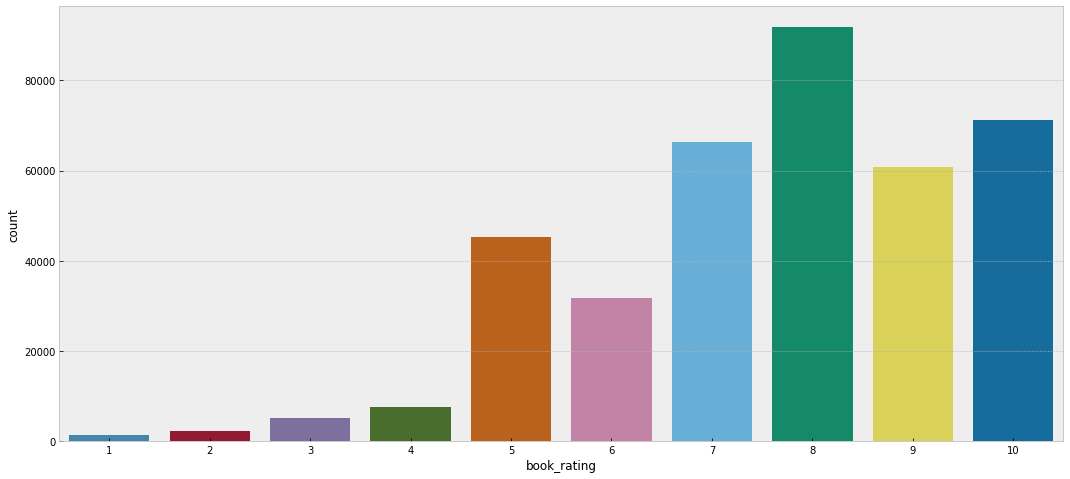

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
sns.countplot(data=ratings_1to10,x='book_rating',ax=ax)

In [ ]:
print(dataset.columns.tolist())

['user_id', 'Location', 'Age', 'Country', 'ISBN', 'book_rating', 'Count_All_Rate', 'rating_Avg', 'rating_sum', 'Book_Title', 'Book_Author', 'Year_Of_Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


In [ ]:
dataset=dataset[['user_id', 'Location', 'Age', 'Country', 'ISBN', 'book_rating', 'rating_Avg','rating_sum', 'Count_All_Rate', 'Book_Title', 'Book_Author', 'Year_Of_Publication', 'Publisher']]

In [ ]:
missing_zero_values_table(dataset)

Your selected dataframe has 13 columns and 383842 Rows.
There are 0 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type
0,user_id,0,0.0,int64
1,Location,0,0.0,object
2,Age,0,0.0,float64
3,Country,0,0.0,object
4,ISBN,0,0.0,object
5,book_rating,0,0.0,int64
6,rating_Avg,0,0.0,float64
7,rating_sum,0,0.0,int64
8,Count_All_Rate,0,0.0,int64
9,Book_Title,0,0.0,object


# **Simple Popularity based Recommendation System**

In [ ]:
cm=sns.light_palette('red',as_cmap=True)
# count all rate means include users rated 0 to book
popular=dataset.groupby(['Book_Title','Count_All_Rate','rating_Avg','rating_sum']).size().reset_index().sort_values(['rating_sum','rating_Avg',0],
                                                                                                            ascending=[False,False,True])[:20]
popular.rename(columns={0:'Count_Rate'},inplace=True)
popular.style.background_gradient(cmap=cm)

,Book_Title,Count_All_Rate,rating_Avg,rating_sum,Count_Rate
121545,The Lovely Bones: A Novel,1295,8.185290,5787,707
113060,The Da Vinci Code,883,8.435318,4108,487
126798,The Red Tent (Bestselling Backlist),723,8.182768,3134,383
49901,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),571,8.939297,2798,313
128230,The Secret Life of Bees,615,8.452769,2595,307
145830,Wild Animus,2502,4.390706,2551,581
32875,Divine Secrets of the Ya-Ya Sisterhood: A Novel,732,7.887500,2524,320
144858,Where the Heart Is (Oprah's Book Club (Paperback)),585,8.142373,2402,295
46479,Girl with a Pearl Earring,526,7.982014,2219,278
8919,Angels & Demons,586,8.100372,2179,269


# **Collaborative Filtering**

The First step is to find persons who are similar to user
so must be calculated distance
and distance can calculate by those methods

Manhattan distance

Euclidean distance

Minkowski distance

In [ ]:
dataset.head()

,user_id,Location,Age,Country,ISBN,book_rating,rating_Avg,rating_sum,Count_All_Rate,Book_Title,Book_Author,Year_Of_Publication,Publisher
0,8,"timmins, ontario, canada",35.311347,canada,0002005018,5,7.666667,69,14,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
1,11676,"n/a, n/a, n/a",34.241348,other,0002005018,8,7.666667,69,14,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,67544,"toronto, ontario, canada",30.000000,canada,0002005018,8,7.666667,69,14,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,116866,"ottawa, ,",34.241348,other,0002005018,9,7.666667,69,14,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
4,123629,"kingston, ontario, canada",35.311347,canada,0002005018,9,7.666667,69,14,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada


In [ ]:
def manhattan(rating1,rating2):
    "Computes the Manhattan distance. Both rating1 and rating2 are dictionaries"
    user1=dict(zip(dataset.loc[dataset.user_id==rating1].Book_Title,dataset.loc[dataset.user_id==rating1].book_rating))
    user2=dict(zip(dataset.loc[dataset.user_id==rating2].Book_Title,dataset.loc[dataset.user_id==rating2].book_rating))
    distance = 0
    for key in user1:
        if key in user2:
            distance += abs(user1[key] - user2[key])
    return distance
print(f'Manhattan distance between user number 8 and 11676 : {manhattan(8,11676)}')

Manhattan distance between user number 8 and 11676 : 3


In [ ]:
def euclidean(rating1,rating2):
    "Computes the Euclidean distance. Both rating1 and rating2 are dictionaries"
    user1=dict(zip(dataset.loc[dataset.user_id==rating1].Book_Title,dataset.loc[dataset.user_id==rating1].book_rating))
    user2=dict(zip(dataset.loc[dataset.user_id==rating2].Book_Title,dataset.loc[dataset.user_id==rating2].book_rating))
    distance = 0
    for key in user1:
        if key in user2:
            distance += math.pow(abs(user1[key]-user2[key]),2)
    return math.sqrt(distance)
print(f'Euclidean distance between user number 8 and 11676 : {euclidean(8,11676)}')  

Euclidean distance between user number 8 and 11676 : 3.0


In [ ]:
def minkowski(rating1,rating2,r):
    """Computes the Minkowski distance. Both rating1 and rating2 are dictionaries"""
    user1=dict(zip(dataset.loc[dataset.user_id==rating1].Book_Title,dataset.loc[dataset.user_id==rating1].book_rating))
    user2=dict(zip(dataset.loc[dataset.user_id==rating2].Book_Title,dataset.loc[dataset.user_id==rating2].book_rating))
    distance = 0
    for key in user1:
        if key in user2:
            distance += math.pow(abs(user1[key]-user2[key]),r)
    return math.pow(distance,1/r)
print(f'Minkowski distance between user number 8 and 11676 : {minkowski(8,11676,2)}') 

Minkowski distance between user number 8 and 11676 : 3.0


In [ ]:
counts1 = ratings_1to10['user_id'].value_counts()
ratings_1to10 = ratings_1to10[ratings_1to10['user_id'].isin(counts1[counts1 >= 100].index)]
counts = ratings_1to10['book_rating'].value_counts()
ratings_1to10 = ratings_1to10[ratings_1to10['book_rating'].isin(counts[counts >= 100].index)]

In [ ]:
dataset.user_id.unique().tolist()[500]

192762

In [ ]:
def computeNearestNeighbor(username):
    """Creates a sorted list of users based on their distance 
    to username """
    #users = list(dataset.user_id.unique())
    users=dataset.user_id.unique().tolist()[:500]
    distances = []
    for user in users:
        if user != username:
            distance = manhattan(user,username)
            distances.append((distance,user))
    # sort based on distance -- closest first
    distances.sort()
    return distances
computeNearestNeighbor(192762)


[(0, 8),
 (0, 9),
 (0, 12),
 (0, 14),
 (0, 16),
 (0, 17),
 (0, 19),
 (0, 22),
 (0, 26),
 (0, 367),
 (0, 1032),
 (0, 2766),
 (0, 3373),
 (0, 3542),
 (0, 4017),
 (0, 4225),
 (0, 5555),
 (0, 6242),
 (0, 7409),
 (0, 7841),
 (0, 8066),
 (0, 8115),
 (0, 8253),
 (0, 8570),
 (0, 8720),
 (0, 9417),
 (0, 10215),
 (0, 10314),
 (0, 11104),
 (0, 11601),
 (0, 12863),
 (0, 13850),
 (0, 14449),
 (0, 14801),
 (0, 15720),
 (0, 15775),
 (0, 17402),
 (0, 17950),
 (0, 19011),
 (0, 19336),
 (0, 20265),
 (0, 21402),
 (0, 21576),
 (0, 21870),
 (0, 22365),
 (0, 22463),
 (0, 22625),
 (0, 23902),
 (0, 24194),
 (0, 24525),
 (0, 26084),
 (0, 27472),
 (0, 27624),
 (0, 28056),
 (0, 28222),
 (0, 28477),
 (0, 28731),
 (0, 29067),
 (0, 29855),
 (0, 29981),
 (0, 30035),
 (0, 30461),
 (0, 30487),
 (0, 30489),
 (0, 31556),
 (0, 32089),
 (0, 33974),
 (0, 34193),
 (0, 35718),
 (0, 35945),
 (0, 36003),
 (0, 36197),
 (0, 36327),
 (0, 36506),
 (0, 36907),
 (0, 36938),
 (0, 37400),
 (0, 37511),
 (0, 37712),
 (0, 37950),
 (0, 38

In [ ]:
def recommend(username):
    """Give list of recommendations"""
    # first find nearest neighbor
    nearest=computeNearestNeighbor(username)[0][1]
    recommendations=[]
    # now find bands neighbor rated that user didn't
    neighborRatings = dataset.loc[dataset.user_id==nearest].Book_Title.tolist()
    userRatings = dataset.loc[dataset.user_id==username].Book_Title.tolist()
    for artist in neighborRatings:
        if not artist in userRatings:
            recommendations.append((artist,int(dataset[(dataset.Book_Title==artist) & (dataset.user_id==nearest)].book_rating)))
    return sorted(recommendations,key=lambda artistTuple : artistTuple[1],reverse=True)
print(recommend(192762))

[('Goodbye to the Buttermilk Sky', 7), ('The Witchfinder (Amos Walker Mystery Series)', 6), ('More Cunning Than Man: A Social History of Rats and Man', 6), ('Clara Callan', 5), ("Where You'll Find Me: And Other Stories", 5), ('The Middle Stories', 5), ('Jane Doe', 5)]
